In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# reading data
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.isna().sum()  # checking null values

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
# dividing data into X and Y
X=df.drop('label',axis=1)
y=df['label']


In [7]:
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [8]:
# dividing into train test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=100)

In [9]:
print(X_train.shape)
print(X_test.shape)

(29400, 784)
(12600, 784)


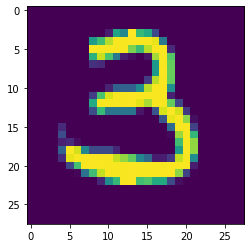

In [10]:
import matplotlib.pyplot as plt
digit1=X_train.values[3].reshape(28,28)
plt.imshow(digit1)
plt.show()

In [11]:
# checking target corresponding to 4th index 32294
y_train[32294]

3

In [12]:

pipe=make_pipeline(StandardScaler(),PCA())  # pipeline to standardize and pca with all components
pipe.fit(X_train)


Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

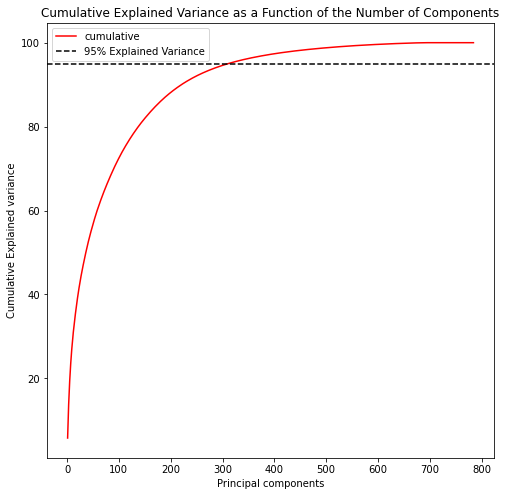

In [13]:
# we will check the number of components required toget 95% explained variance
variance=pipe.named_steps['pca'].explained_variance_ratio_
cumvar=np.cumsum(variance)*100
plt.figure(figsize=(8,8))
plt.plot(range(1,len(cumvar)+1),cumvar,color='red',label='cumulative')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [14]:
# applying pca pipeline on train and test data with 95 % explained variance'
pipe=make_pipeline(StandardScaler(),PCA(0.95))
pipe.fit(X_train)
X_train_pca=pipe.transform(X_train)
X_test_pca=pipe.transform(X_test)

In [15]:
# checking data
print(X_train_pca.shape)

(29400, 311)


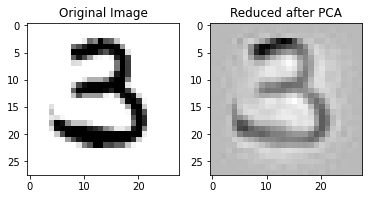

In [16]:
# checking image quality before and after compression
sample = X_train.values[3]
sample.shape = (28,28)


a = plt.subplot(1,2,1)
a.set_title('Original Image')
plt.imshow(sample, cmap = plt.cm.gray_r)

sample = pipe.named_steps['pca'].inverse_transform(X_train_pca[3])
sample.shape = (28,28)

b = plt.subplot(1,2,2)
b.set_title("Reduced after PCA")
plt.imshow(sample, cmap = plt.cm.gray_r)

In [17]:
# creating parameters for grid search 
params=[{'penalty': ['l2'],
         'C': [1.25,1.5],
         'solver': ['lbfgs']}
       ] 



In [18]:
grid=GridSearchCV(estimator=LogisticRegression(random_state=42,n_jobs=-1),param_grid=params,scoring='accuracy',n_jobs=-1,verbose=5)


In [19]:
grid

GridSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [1.25, 1.5], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
             scoring='accuracy', verbose=5)

In [20]:
# fitting gridsearch on train data
grid.fit(X_train_pca,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.5s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.5s finished


GridSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [1.25, 1.5], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
             scoring='accuracy', verbose=5)

In [21]:
# getting best paramaters and accuracy score
grid.best_params_

{'C': 1.25, 'penalty': 'l2', 'solver': 'lbfgs'}

In [22]:
# getting best cv score
grid.best_score_

0.9148299319727892

In [23]:
# we will use the best estimator model from grid search to predict 
y_pred=grid.best_estimator_.predict(X_train_pca)
# checking accuracy on validation set
accuracy_score(y_train,y_pred)

0.941734693877551

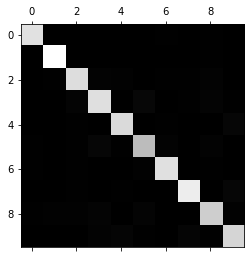

In [24]:
# printing the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat=confusion_matrix(y_train,y_pred)
plt.matshow(confusion_mat,cmap=plt.cm.gray)
plt.show()

#### This shows that the digits were mostly classified correctly as the diagonal has the highest values

In [25]:
confusion_mat # visualising the confusion matrix

array([[2819,    0,    8,    4,    3,   12,   24,    2,   17,    1],
       [   0, 3200,   12,    9,    2,    8,    2,    5,   17,    5],
       [  11,   16, 2774,   41,   27,   11,   21,   24,   45,    8],
       [   9,   11,   58, 2788,    1,   93,    5,   19,   52,   19],
       [   4,   11,   13,    1, 2728,    3,   17,    7,    9,   75],
       [  20,    9,   22,   78,   21, 2361,   40,    7,   47,   12],
       [  15,    3,   14,    1,   11,   29, 2800,    0,   14,    0],
       [   1,    9,   20,   12,   17,    2,    1, 2970,    5,   80],
       [  17,   36,   26,   60,    4,   61,   11,    7, 2575,   30],
       [   8,   12,    3,   39,   65,   14,    0,   73,   15, 2672]])

In [26]:
row_sums=confusion_mat.sum(axis=1,keepdims=True ) # calculating the sum of each row
TPR=confusion_mat/row_sums # number of correctly predicted labels for all of the actual labels present

In [27]:
np.fill_diagonal(TPR,0)

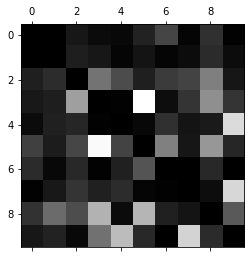

In [28]:
plt.matshow(TPR,cmap=plt.cm.gray)
plt.show()
# we can see that most errors were between: 4 and 9, 3 and 5, 5 and 8

In [29]:
# we will now check the classification metrics like precision, recall, F1 score
from sklearn.metrics import classification_report
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2890
           1       0.97      0.98      0.97      3260
           2       0.94      0.93      0.94      2978
           3       0.92      0.91      0.92      3055
           4       0.95      0.95      0.95      2868
           5       0.91      0.90      0.91      2617
           6       0.96      0.97      0.96      2887
           7       0.95      0.95      0.95      3117
           8       0.92      0.91      0.92      2827
           9       0.92      0.92      0.92      2901

    accuracy                           0.94     29400
   macro avg       0.94      0.94      0.94     29400
weighted avg       0.94      0.94      0.94     29400



In [30]:
X_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")  # reading the test file
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
pca_X_test=pipe.transform(X_test) # scaling and applying pca to test data

In [32]:
y_test_pred=grid.predict(pca_X_test)

In [33]:
y_test_pred    # the values predicted by our model

array([2, 0, 9, ..., 3, 9, 2])

In [34]:
# we will crosscheck our predictions with test data

In [35]:
transformed=pipe.named_steps['pca'].inverse_transform(pca_X_test[0])  # decompressing the index 1 test digit

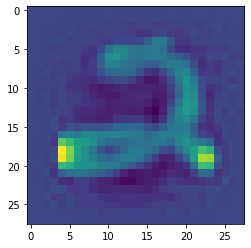

In [36]:
transformed=transformed.reshape(28,28)   # we can see that our model predicts 2 too at index 0
plt.imshow(transformed)
plt.show()

In [37]:
submission = pd.DataFrame({'ImageId': range(1,len(y_test_pred)+1),
                           'Label': y_test_pred})
print(submission)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      7
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [38]:
submission.to_csv('out.csv', header=True, index = False)   # Generating output csv
print(submission)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      7
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
